In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

income = pd.read_csv("/Users/yasaswi/Documents/marlabs/training/datasets/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [17]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = income_model_prep(income) 

In [19]:
X_train.filter(regex='^gen')

,gender_ Male
17765,False
26884,True
17838,True
9524,True
22722,False
...,...
5695,True
8006,True
17745,True
17931,True


# Assignment 1: Simple Tree

1. Build a decision tree with max_depth 3 using the `age`, `hoursperweek` and `gender` features.
2. Calculate accuracy and build a confusion matrix for the test data
3. Plot the tree - which group has the highest probability of making over 50,000?
4. Plot Feature importance - which variable was most important? Are there any we can drop?

In [27]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)
# after creating dummies the categorical column of gender is replaced with gender_ Male as binary column
newCols = ['age', 'hoursperweek', 'gender_ Male']
dt.fit(X_train[newCols], y_train)

DecisionTreeClassifier(max_depth=3)

In [28]:
# Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = dt.predict(X_test[newCols])
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7718886804252658

In [29]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
# we can observe the positive class have less number of good predictions

[[4266  601]
 [ 858  671]]


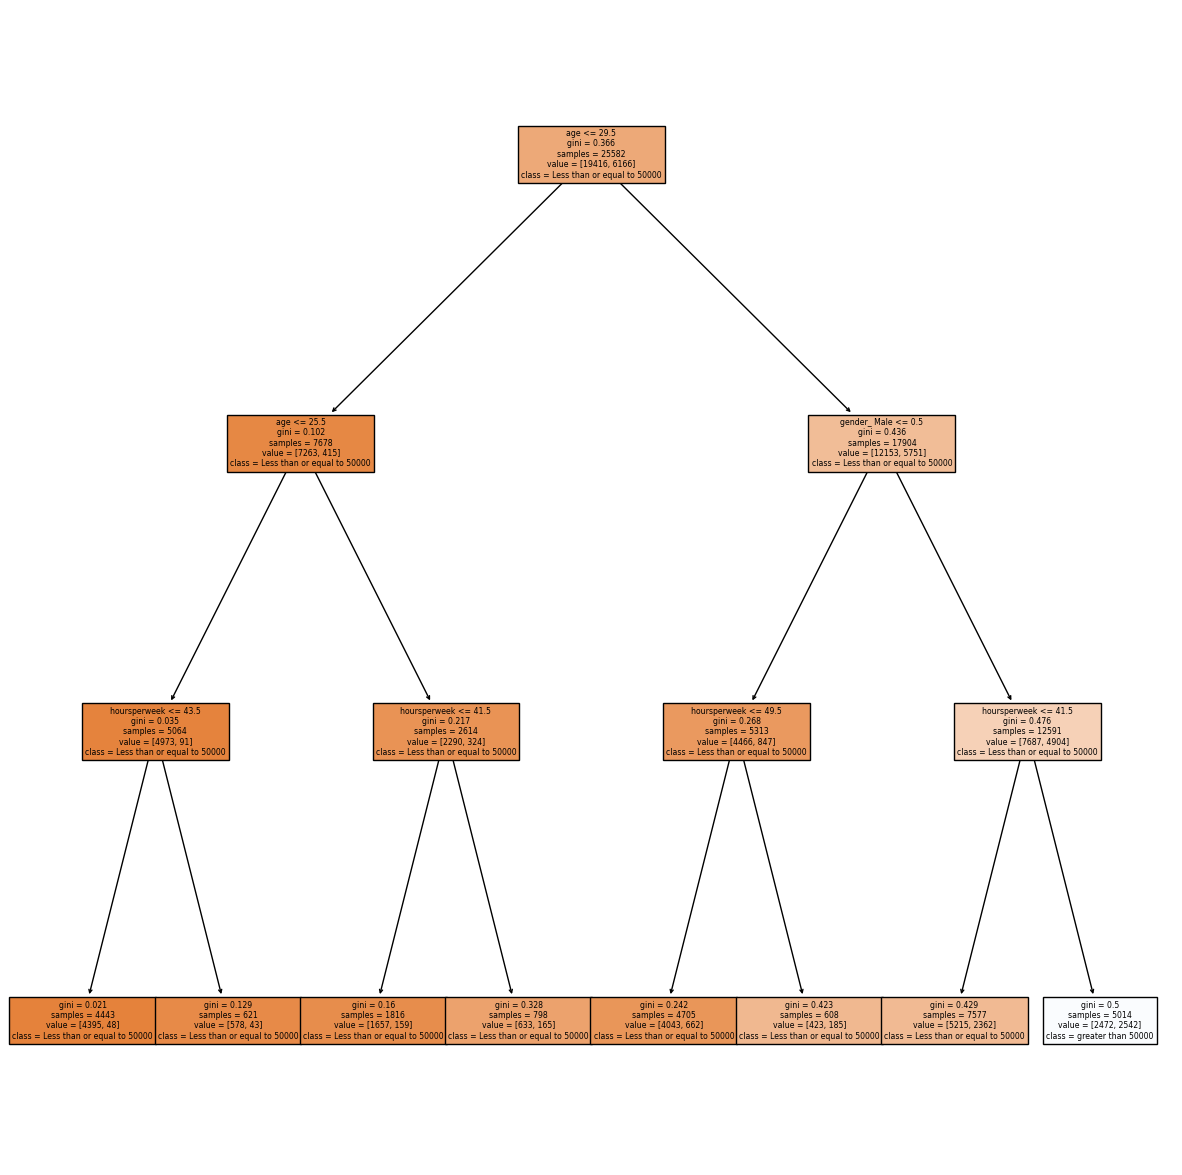

In [43]:
# plot tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))
plot_tree(dt, 
          feature_names=newCols, 
          class_names=["Less than or equal to 50000", "greater than 50000"], 
          filled=True
          )
plt.show()
# Here we can observe that the group age>29.5, gender_ Male > 0.5, hoursperweek > 41.5 leads to greater than 50000

[0.54458503 0.18810887 0.2673061 ]


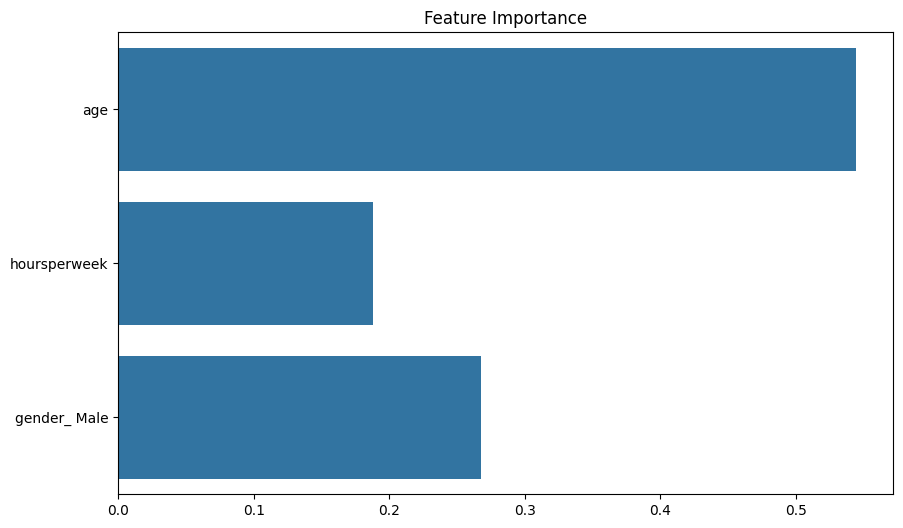

In [46]:
feature_imp = dt.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=newCols)
plt.title('Feature Importance')
print(feature_imp)
plt.show()
# we can observe the variable age is highly important. As the variable hoursperweek still contributes 18% to the model, we should not drop it. So, there are no columns to drop.

# Assignment 2: Hyperparameter Tuning

1. Use cross validation to find the optimal tree parameters. Your process should evaluate different values of max_depth, 'min_samples_leaf', and 'criterion'. 
2. Generate a confusion matrix and report test accuracy, precision, and recall

In [58]:
# Crossvalidation to get best fit hyper parameters using gridsearchCV
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 6, 7, 9, 10, 15, 20],
    'min_samples_leaf': [3, 5, 6, 7, 9, 10, 15, 20],
    'criterion': ['gini', 'entropy', 'log_loss']
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=-1)
gridSearch.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 6, 7, 9, 10, 15, 20],
                         'min_samples_leaf': [3, 5, 6, 7, 9, 10, 15, 20]})

In [59]:
#Best params
gridSearch.best_params_

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 15}

In [62]:
# confusion matrix of best fit hyper parameters
y_pred = gridSearch.best_estimator_.predict(X_test)
con = confusion_matrix(y_test, y_pred)
con

array([[4554,  313],
       [ 649,  880]])

In [67]:
from sklearn.metrics import classification_report, precision_score, recall_score
classificationReport = classification_report(y_test, y_pred, target_names=["lessthan or equal to 50K", "greater than 50K"])
print("Classification Report:")
print(classificationReport)

Classification Report:
                          precision    recall  f1-score   support

lessthan or equal to 50K       0.88      0.94      0.90      4867
        greater than 50K       0.74      0.58      0.65      1529

                accuracy                           0.85      6396
               macro avg       0.81      0.76      0.78      6396
            weighted avg       0.84      0.85      0.84      6396



END